In [1]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import level_finder as lf
import data_visualization as dv
import level_category as lc
from sklearn.cluster import KMeans
import ruptures as rpt

In [2]:
abf_5 = pyabf.ABF("inputs/2024_06_19_0011.abf")
abf_5 = lf.downsample(abf_5, 100)
i_ranges, t_ranges = lf.find_events(abf_5)

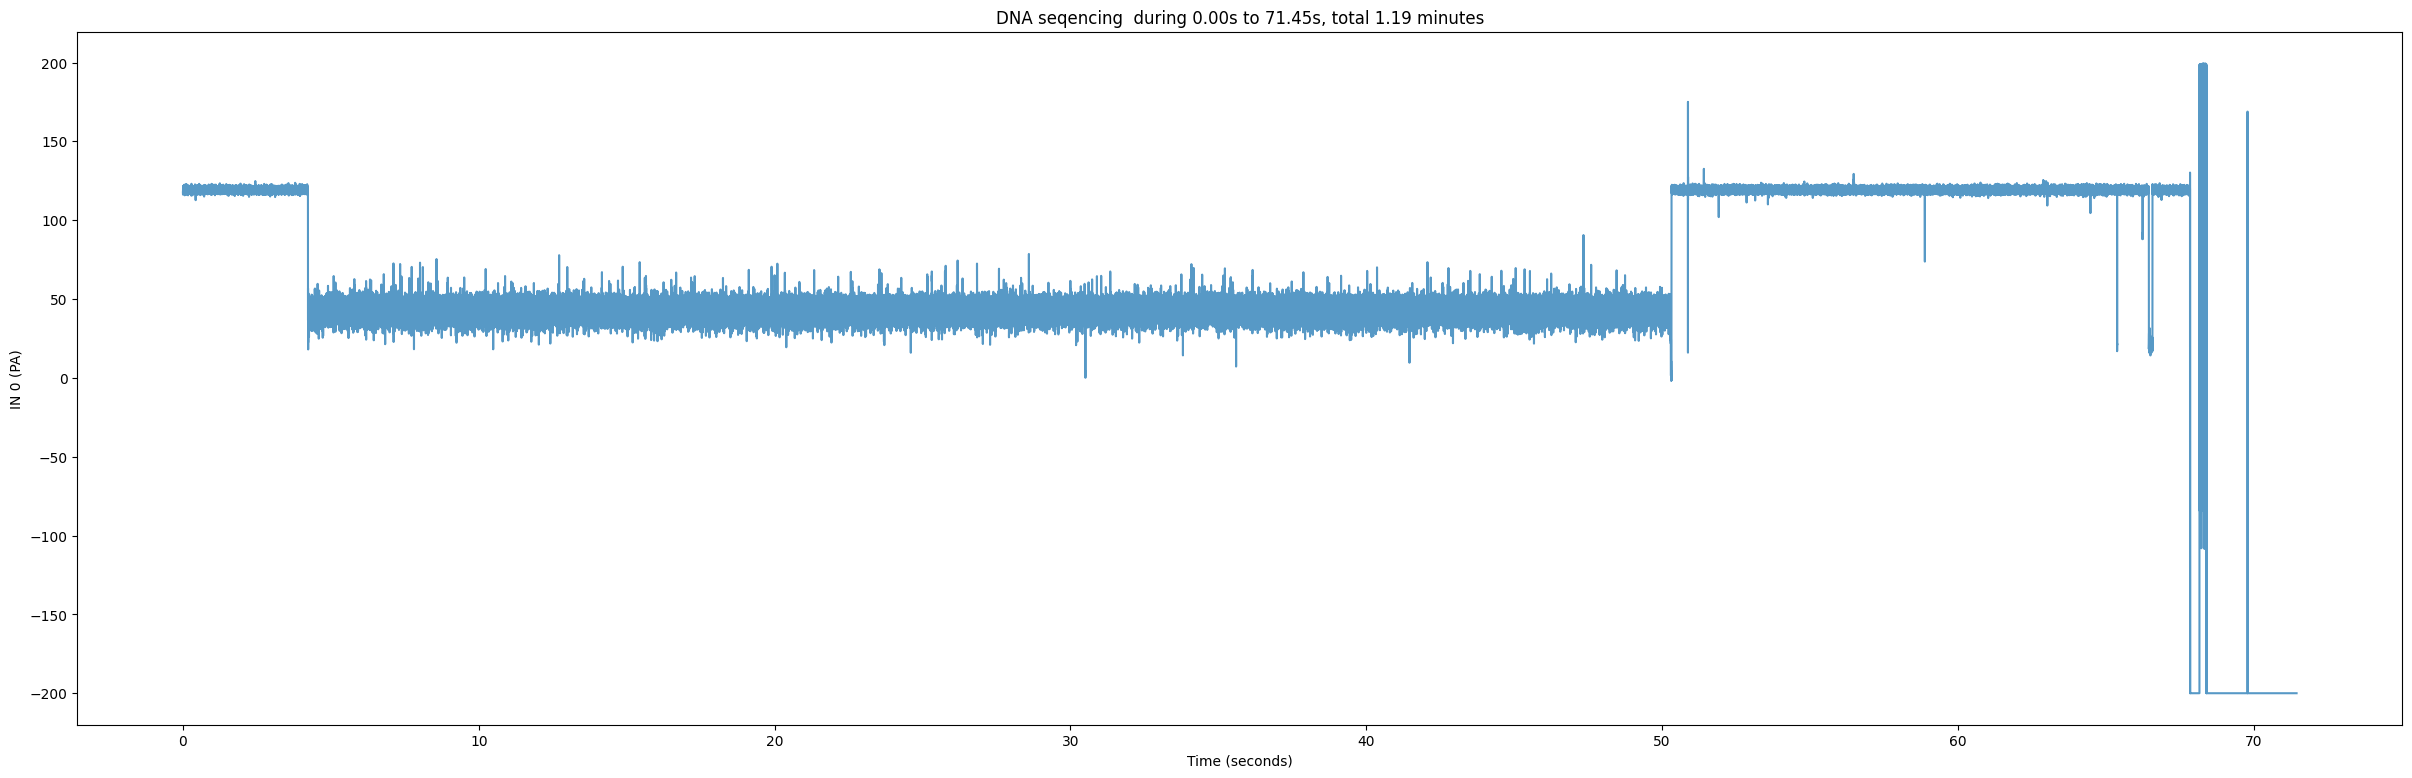

In [3]:
fig = dv.plot_abf(abf_5)

In [4]:
arrs_5 = [0] * len(i_ranges_)
for i in range(len(i_ranges_T1)):
    arrs_T1[i] = abf_T1.sweepY[i_ranges_T1[i][0]:i_ranges_T1[i][1]]
    

In [5]:
arrs_T2 = [0] * len(i_ranges_T2)
for i in range(len(i_ranges_T2)):
    arrs_T2[i] = abf_T2.sweepY[i_ranges_T2[i][0] : i_ranges_T2[i][1]]

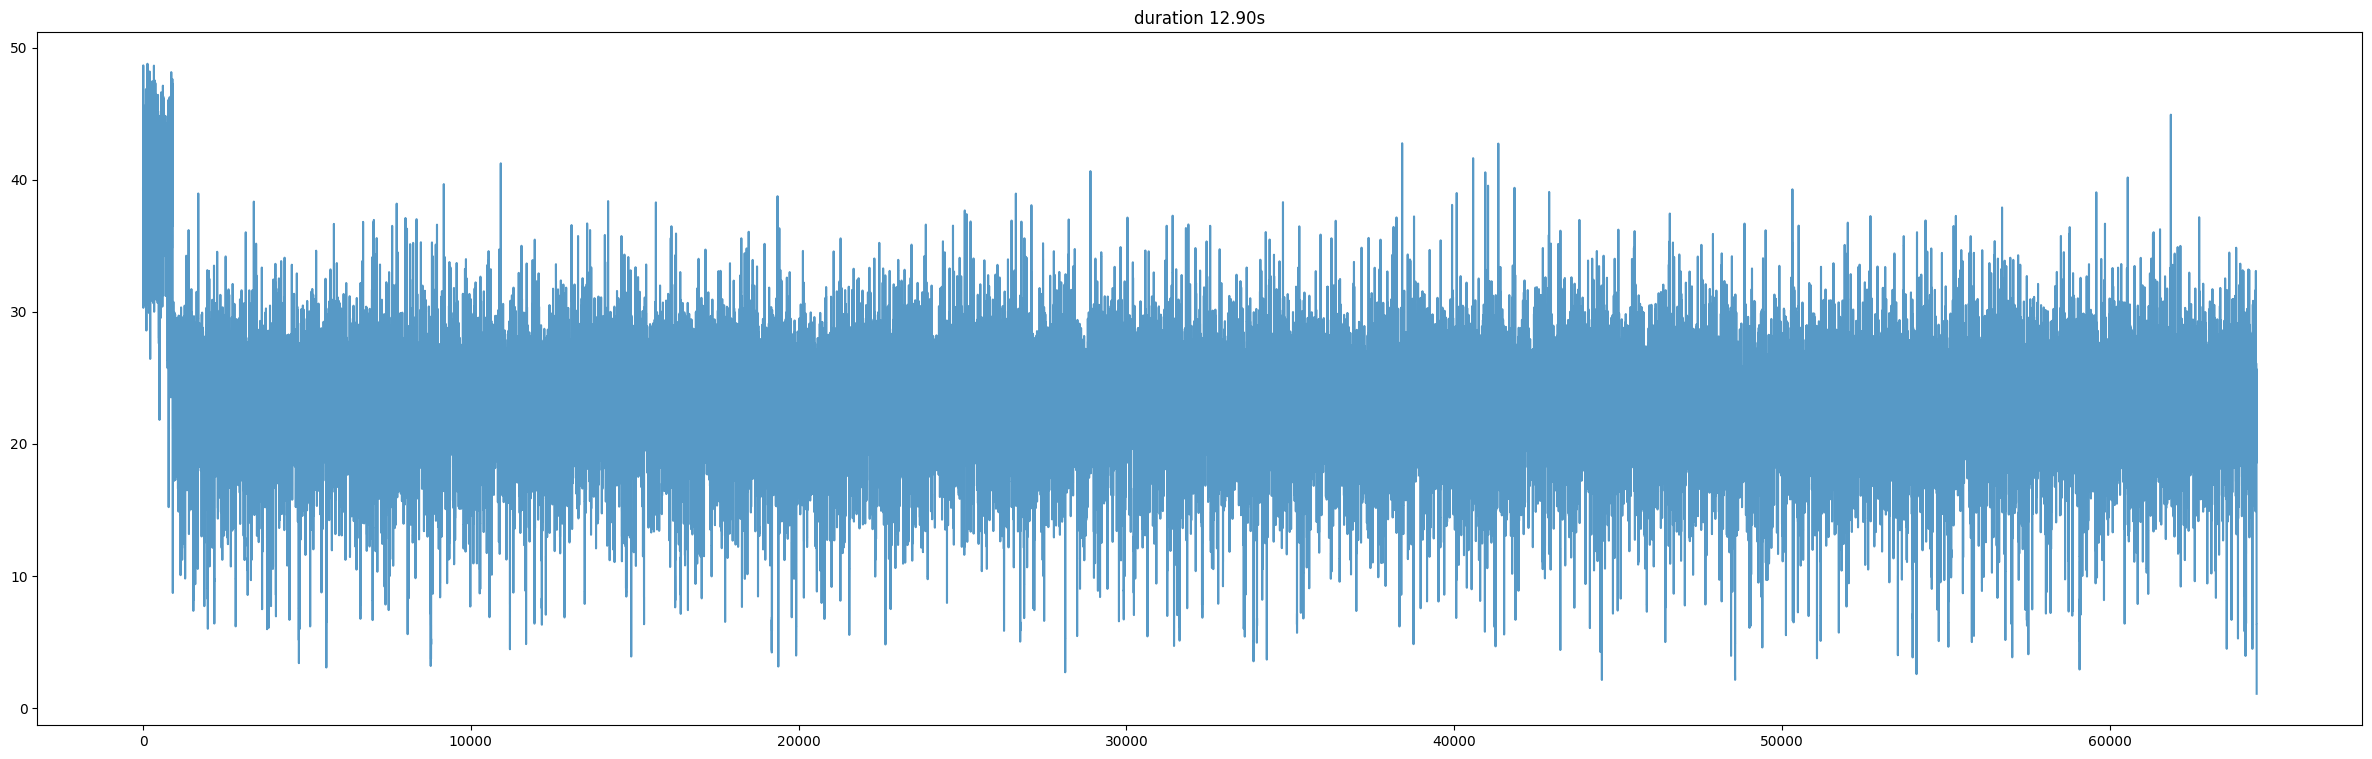

In [6]:
fig=dv.plot_arr(arrs_T2[0])

In [7]:
arrs_T1_copy = arrs_T1.copy()
for i in range(len(arrs_T1_copy)):
    arrs_T1_copy[i] = lf.replace_outliers_with_bounds(arrs_T1_copy[i], window_size=250)

In [8]:
arrs_T2_copy = arrs_T2.copy()
for i in range(len(arrs_T2_copy)):
    arrs_T2_copy[i] = lf.replace_outliers_with_bounds(arrs_T2_copy[i], window_size=250)

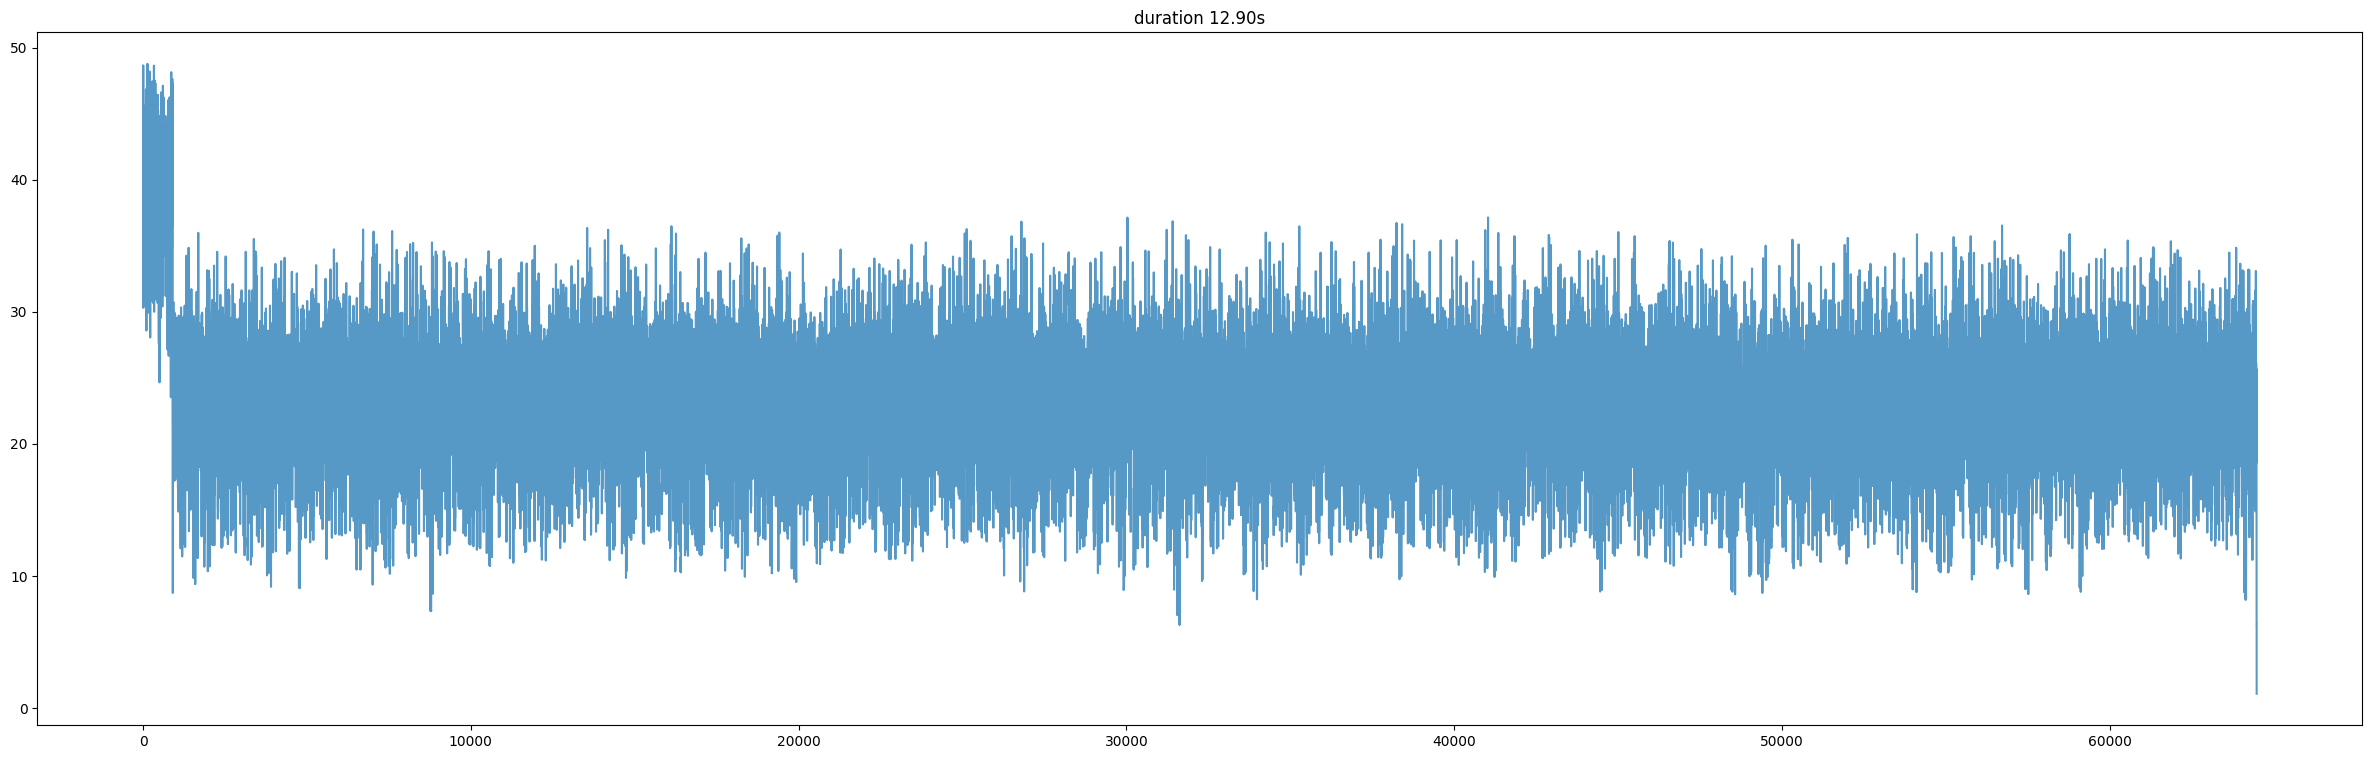

In [9]:
fig = dv.plot_arr(arrs_T2_copy[0])

In [10]:
bkps = []
signal = arrs_T2_copy[0].reshape(-1, 1)

(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

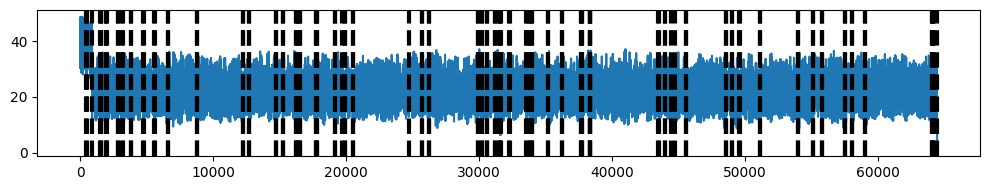

In [11]:
algo_l2 = rpt.Dynp(model="l2").fit(signal)
result_mean = algo_l2.predict(n_bkps=120)
rpt.display(signal, bkps, result_mean)

In [12]:
# algo = rpt.Dynp(model="normal").fit(signal)
# result = algo.predict(n_bkps=120)
# rpt.display(signal, bkps, result)

In [13]:
def calc_level4arr(arr, sub_change_points) -> pd.DataFrame:
    """
    index
    change_point
    level: i和i+1之间的平均值
    """
    df = pd.DataFrame(columns=["change_point", "level"])
    df = df.astype({"change_point": int, "level": float})
    for i in range(len(sub_change_points) - 1):
        df.loc[len(df)] = {
            "change_point": sub_change_points[i],
            "level": np.mean(arr[sub_change_points[i] : sub_change_points[i + 1]]),
        }
    df.loc[len(df)] = {"change_point": sub_change_points[-1], "level": df.iloc[-1]["level"]}  # 补全终点
    return df

In [14]:
def plot_arr_lvls(arr, df_lvl, range_type="default", start_index=None, end_index=None, title_prefix=""):
    """
    在abf图上画出level的step图
    """
    fig = plt.figure(figsize=(30, 9))
    # 作图范围
    if range_type == "typical":
        start_index = 2000
        end_index = 4000
    elif range_type == "default":
        start_index = int(df_lvl.iloc[0]["change_point"])
        end_index = int(df_lvl.iloc[-1]["change_point"])
    elif range_type == "specified":
        if start_index is None or end_index is None:
            raise ValueError("必须提供 start_index 和 end_index 才能使用 'specified' 范围类型。")

    # label
    plt.title("%s" % title_prefix)
    # 作arr图
    plt.step(
        range(start_index, end_index),
        arr[start_index:end_index],
        alpha=0.75,
        where="mid",
    )
    # 作level图
    x = [
        df_lvl.iloc[i]["change_point"]
        for i in range(len(df_lvl))
        if start_index <= df_lvl.iloc[i]["change_point"] <= end_index
    ]
    y = [
        df_lvl.iloc[i]["level"]
        for i in range(len(df_lvl))
        if start_index <= df_lvl.iloc[i]["change_point"] <= end_index
    ]
    plt.step(x, y, color="r", alpha=0.8, where="post", linewidth=2.0)

    # 标题
    # plt.title(
    #     "DNA seqencing %s during %.2fs to %.2fs, total %.2f minutes"
    #     % (
    #         title_prefix,
    #         start_index / reduction_rate,
    #         end_index / reduction_rate,
    #         duration,
    #     )
    # )
    return fig

/home/xjtu/miniconda3/envs/DNA-sequencing/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xjtu/miniconda3/envs/DNA-sequencing/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/xjtu/miniconda3/envs/DNA-sequencing/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xjtu/miniconda3/envs/DNA-sequencing/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/xjtu/miniconda3/envs/DNA-sequencing/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xjtu/miniconda3/envs/DNA-sequencing/lib/pytho

ValueError: x and y must have same first dimension, but have shapes (64018,) and (25269,)

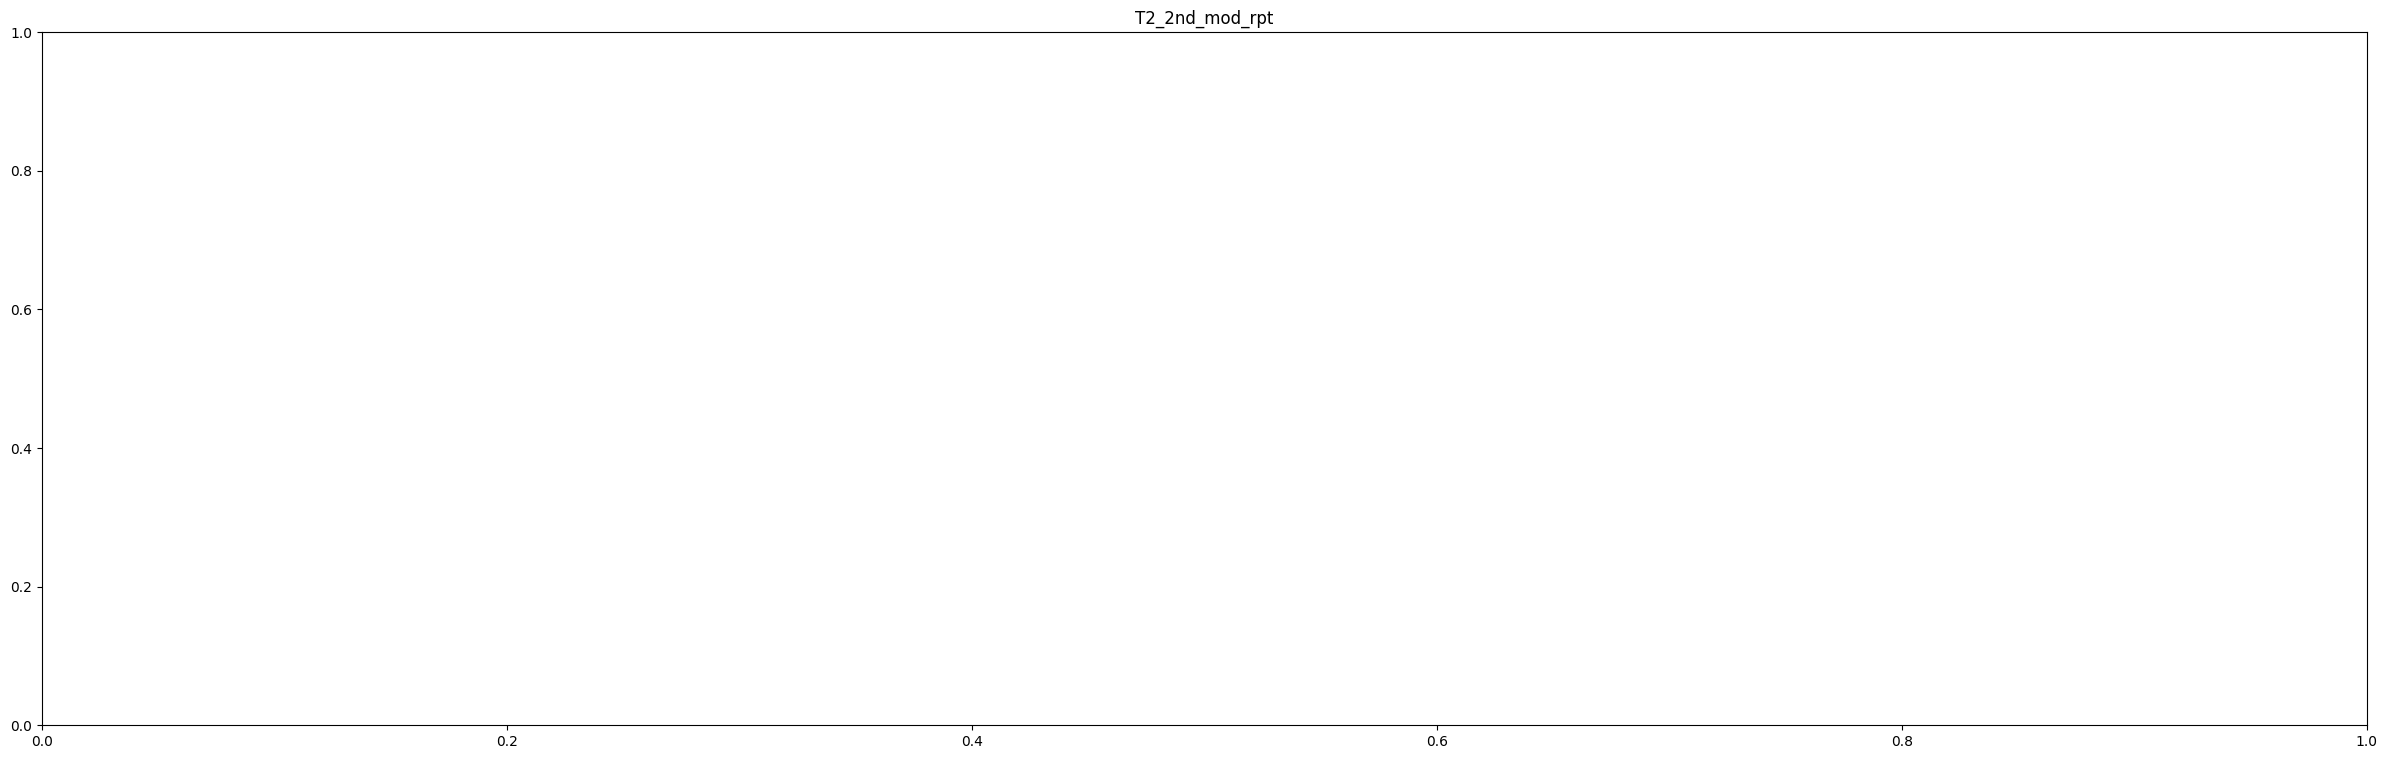

In [15]:
change_points = result_mean
lvl = calc_level4arr(arrs_T2_copy[1], change_points)
lvl.to_csv("outputs/lvl_T2_2nd_mod_rpt.csv", index=False)

fig = plot_arr_lvls(arrs_T2_copy[1], lvl, range_type="default", title_prefix="T2_2nd_mod_rpt")
fig = plot_arr_lvls(
    arrs_T1_copy[1],
    lvl,
    range_type="specified",
    start_index=2000,
    end_index=4000,
    title_prefix="T2_2nd_mod_rpt",
)

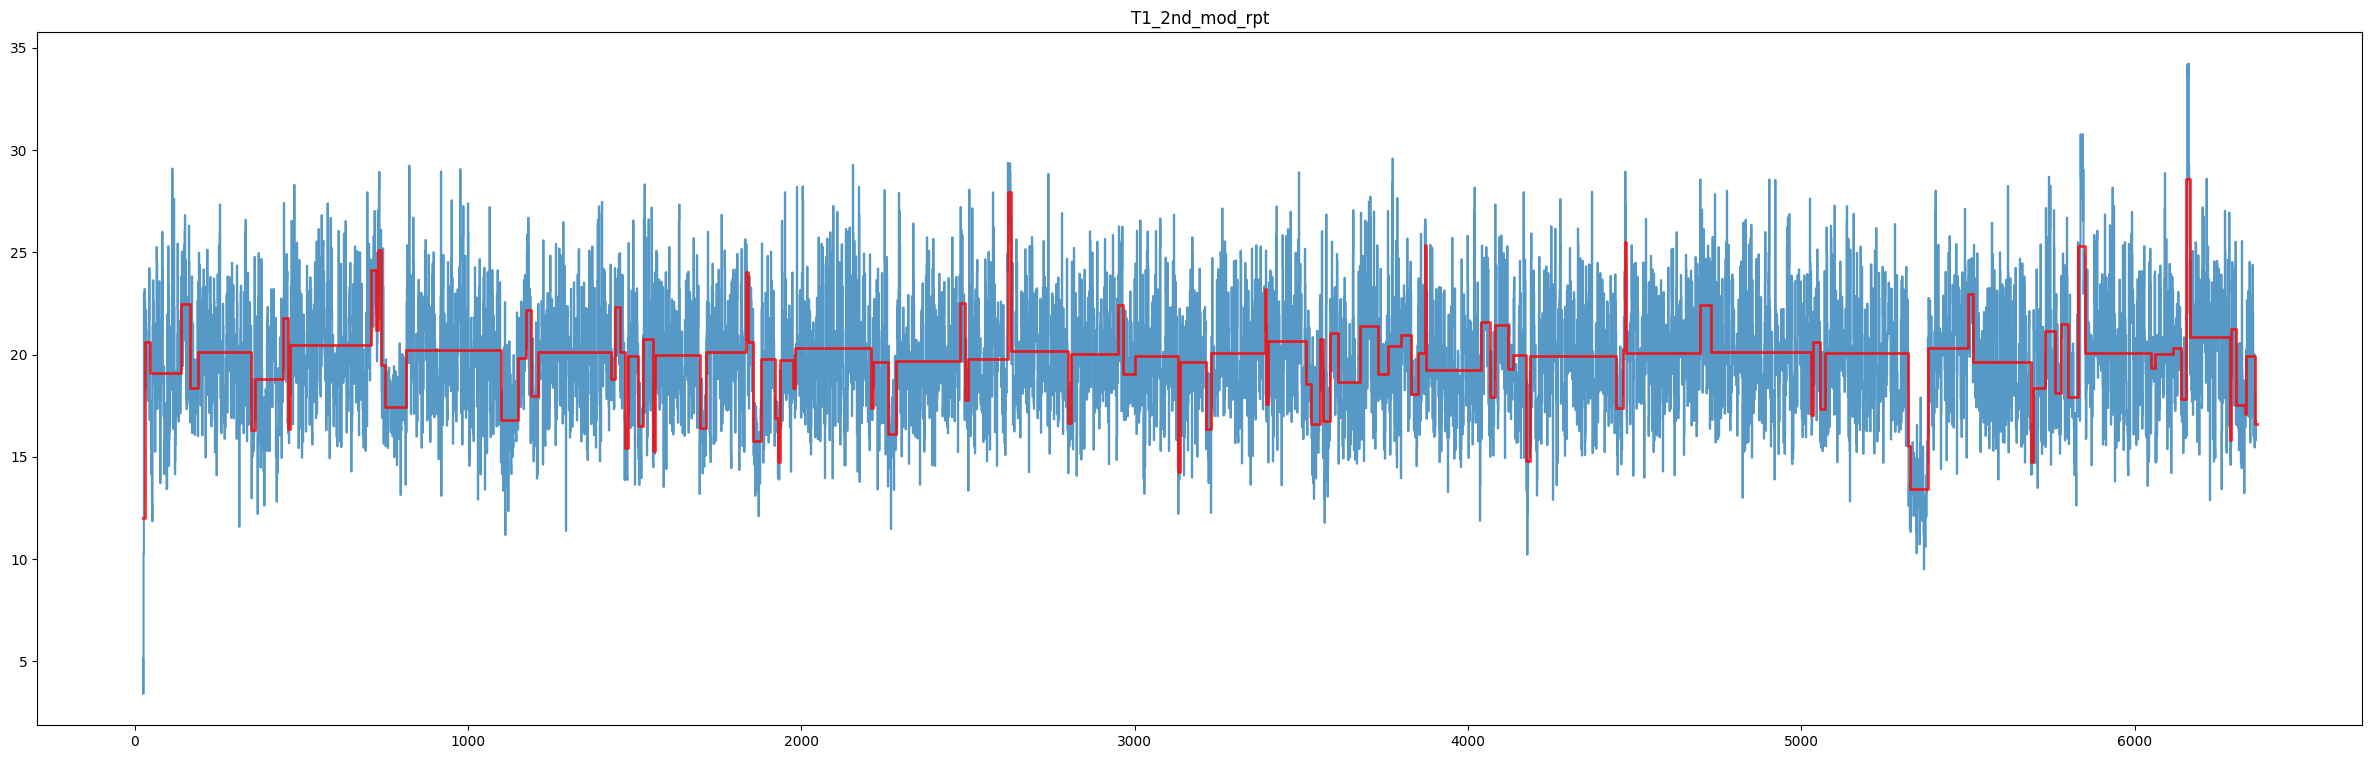

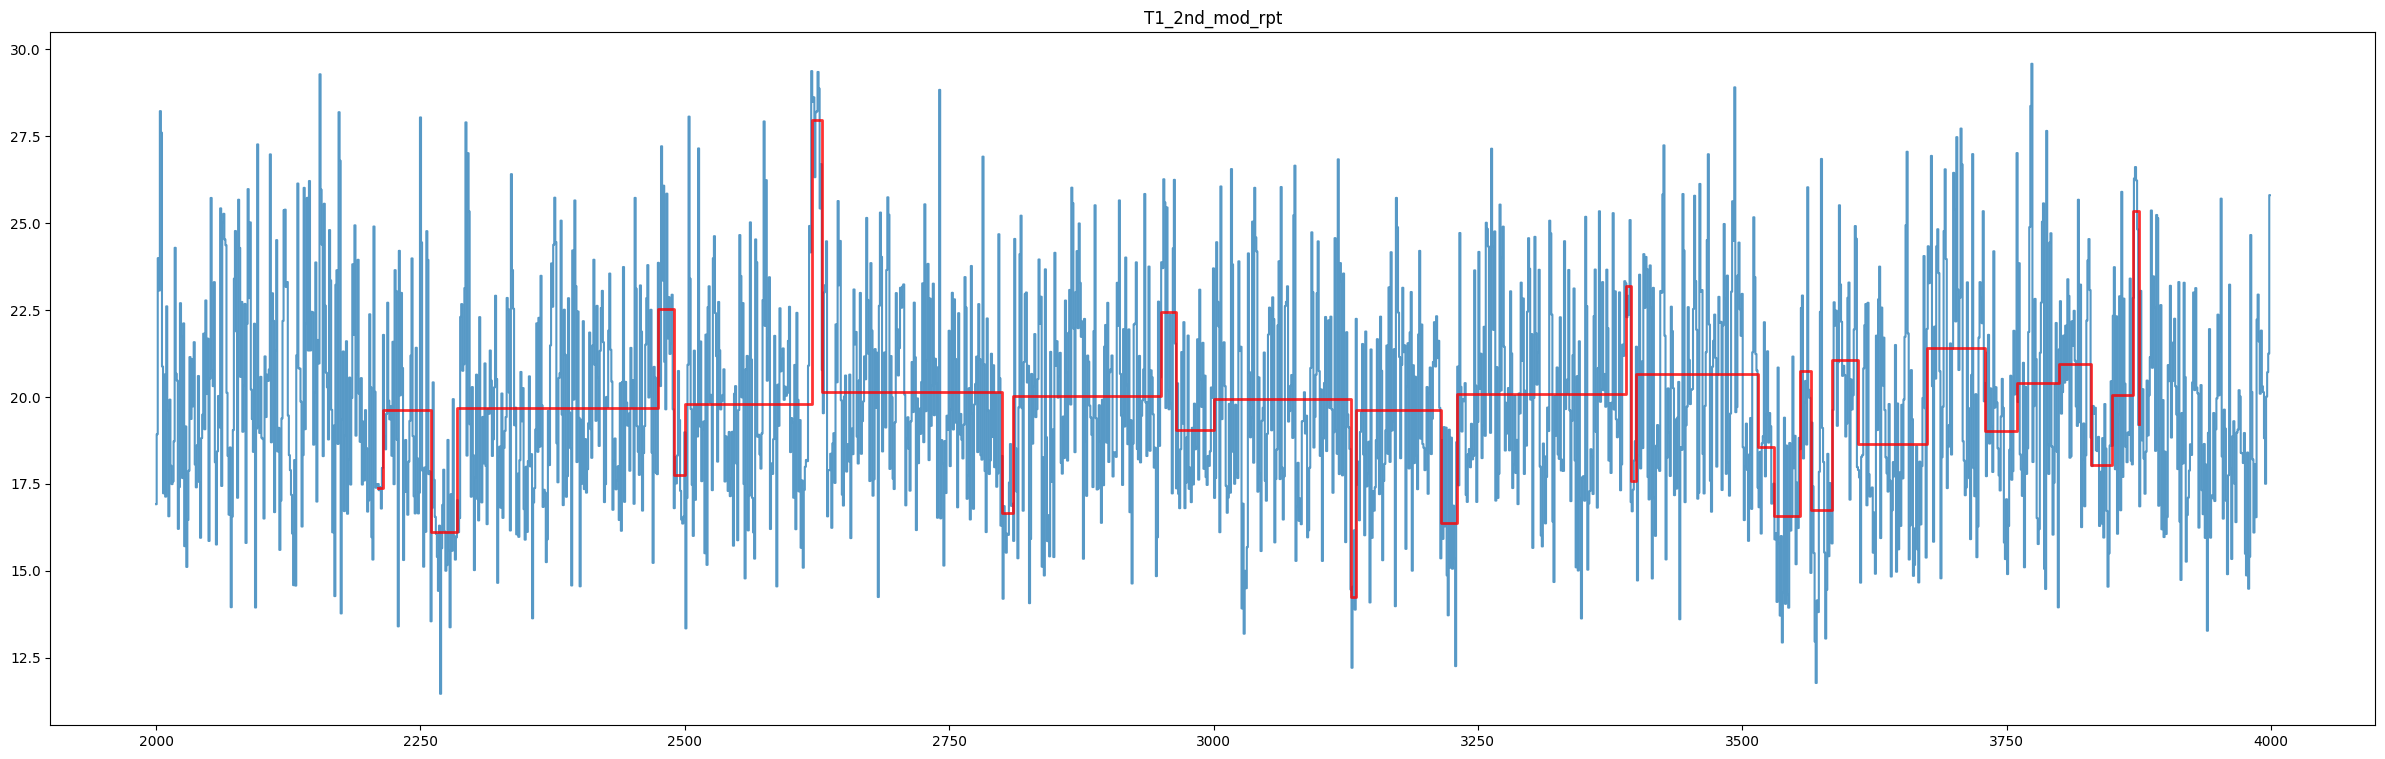

In [ ]:
change_points = result
lvl = calc_level4arr(arrs_T2_copy[1], change_points)
lvl.to_csv("outputs/lvl_T2_2nd_mod_rpt.csv", index=False)

fig = plot_arr_lvls(arrs_T2_copy[1], lvl, range_type="default",title_prefix="T2_2nd_mod_rpt")
fig = plot_arr_lvls(arrs_T2_copy[1], lvl, range_type="specified",start_index=2000, end_index=4000,title_prefix="T2_2nd_mod_rpt")

In [ ]:
from config import seq_A_modified

In [ ]:
change_pts_lvl = pd.read_csv("outputs/lvl_T1_2nd_mod_rpt.csv")
base_lvl_map = lc.classify_level(change_pts_lvl, seq_A_modified)
with open("outputs/base_lvl_map_T1_2nd_mod_rpt.txt", "w") as file:
    file.write(str(base_lvl_map))
change_pts_lvl_base = lc.abf2base(change_pts_lvl, base_lvl_map)
change_pts_lvl_base.to_csv("outputs/lvl_T1_2nd_mod_rpt_base.csv", index=False)

In [ ]:
lc.seq2base(seq_A_modified)

['GCAT',
 'GTGT',
 'TGTC',
 'ATGC',
 'CTTG',
 'CTTT',
 'AACC',
 'AAAA',
 'TCGT',
 'CTAA',
 'AGCA',
 'ATTC',
 'CGGT',
 'GGTC',
 'GTAG',
 'TGCG',
 'CATT',
 'TAAG',
 'TCTG',
 'TGCA',
 'CCGC',
 'GCTT',
 'GTCG',
 'ACCT',
 'AAGC',
 'GGCT',
 'GTTT',
 'GCCG',
 'GCAG',
 'GCCT',
 'CGTA',
 'TTTT',
 'CCGT',
 'CCCG',
 'GCTA',
 'CGCC',
 'TCGG',
 'AGGT',
 'GCTC',
 'AGCC',
 'TGTT',
 'CGCT',
 'GTCC',
 'AAAC',
 'CAGG',
 'TCGC',
 'CTGC',
 'TTTG',
 'CGCG',
 'TTCC',
 'CTGT',
 'CCTT',
 'GCGT',
 'CCTG',
 'GCGC',
 'TAGC',
 'TCTC',
 'GTTC',
 'GTCT',
 'TCCG',
 'TCCT',
 'CGTC',
 'CATG',
 'CCGG',
 'GTGC',
 'TCCC',
 'TTGC',
 'CTCG',
 'TTTC',
 'CGTT',
 'TTGT',
 'TTCT',
 'CGTG',
 'CTTC',
 'CTCA',
 'CGGC',
 'TGCT',
 'TGTG',
 'TCAT',
 'TGCC',
 'TTCG']